In [1]:
!pip install gym box2d-py gym[box2d]
# !pip install gym[box2d] 

     |████████████████████████████████| 450kB 8.0MB/s 


In [0]:
import random
from collections import deque

import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

#from IPython import display
import matplotlib
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')


EPISODES = 550
TEST_EPISODES = 300
BATCH_SIZE = 64
UPDATE_MODEL = 10
ACTION_REPEAT = 4

device = torch.device('cpu')

In [0]:
class Net(nn.Module):
    def __init__(self, n_input, n_output):
        super(Net, self).__init__()
        self.layer1 = nn.Linear(n_input, 64, bias=True)
        self.layer2 = nn.Linear(64, 64, bias=True)
        self.layer3 = nn.Linear(64, n_output, bias=True)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x 

In [0]:
def get_e_greedy_action(rlnet, state, n_actions, epsilon):
    if np.random.random() < epsilon:
      return torch.tensor([[np.random.choice(range(n_actions))]], dtype=torch.long)

    with torch.no_grad():
      state = torch.tensor(state)
      max_action = rlnet(state).argmax().view(1,1)

    return max_action


In [0]:
def get_batch(buffer):
    if len(buffer) < BATCH_SIZE: return None
    
    smple = random.sample(buffer, BATCH_SIZE)
    
    # https://www.geeksforgeeks.org/python-get-first-element-of-each-sublist/
    states = torch.FloatTensor(list(zip(*smple))[0])
    actions = torch.LongTensor(list(zip(*smple))[1]).view(-1, 1)
    next_states = torch.FloatTensor(list(zip(*smple))[2])
    rewards = torch.FloatTensor(list(zip(*smple))[3]).view(-1, 1)
    terminal = torch.FloatTensor(list(zip(*smple))[4]).view(-1, 1)
    
    batch = (states, actions, next_states, rewards, terminal)
    return batch


In [0]:

def train_model(rlnet, tgtnet, optimizer, batch, gamma):
    if not batch: return rlnet, tgtnet, optimizer

    # train on random sample
    states, actions, next_states, rewards, terminal = batch

    pred_vals = rlnet(states).gather(1, actions)

    true_vals = tgtnet(next_states).detach().max(1)[0].unsqueeze(1)
    true_vals = true_vals * gamma * (1 - terminal)
    true_vals = rewards + true_vals

    # Compute Mean squared loss
    loss = F.mse_loss(pred_vals, true_vals)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return rlnet, tgtnet, optimizer

In [0]:
def run_dqn(env, epsil, epsilon_min, epsilon_decay, gamma, alpha, buffer_len):
    
    n_input, n_output = env.observation_space.shape[0], env.action_space.n

    # Initialize replay memory D to capacity N
    replay = deque(maxlen=buffer_len)

    # Initialize action-value function Q with random weights
    rlnet = Net(n_input, n_output).to(device)
    optimizer = torch.optim.RMSprop(rlnet.parameters(), lr=alpha)

    # Initialize target action-value function ^Q with weights = Q 
    tgtnet = Net(n_input, n_output).to(device)
    tgtnet.load_state_dict(rlnet.state_dict())

    d = deque(maxlen=100)
    eps_reward = []

    for ep in range(EPISODES):
      state = env.reset()
      
      action = get_e_greedy_action(rlnet, state, n_output, epsil).item()

      done = False
      timesteps = 1
      total_reward = 0

      while True:
        timesteps += 1
        
        # get best e-greedy action every 4 steps
        if timesteps % ACTION_REPEAT == 0:
            action = get_e_greedy_action(rlnet, state, n_output, epsil).item()

        # execute action in environment
        next_state, reward, done, info  = env.step(action)

        # not done if timeout occurred
        flag = False if timesteps >= 1000 else done
        
        # add rewards for evaluation
        total_reward += reward

        # experience replay
        replay.append([state, action, next_state, reward, flag])

        # Sample random minibatch of transitions
        batch = get_batch(replay)

        # train on batch
        rlnet, tgtnet, optimizer = train_model(rlnet, tgtnet, optimizer, batch, gamma)
        
        # copy over model parameters to target network
        # https://pytorch.org/tutorials/beginner/saving_loading_models.html
        if timesteps % UPDATE_MODEL == 0:
          tgtnet.load_state_dict(rlnet.state_dict())

        state = next_state
        
        if done:
          d.appendleft(total_reward)
          eps_reward.append(total_reward)
          break
            
      # decay epsilon
      epsil = max(epsilon_min, epsil * epsilon_decay)

      print('\rEpisode {} : Average Reward {:.3f}'.format(ep, np.mean(d)), end="")
      if (ep + 1) % 100 == 0:
        print('\rEpisode {} : Average Reward {:.3f}'.format(ep, np.mean(d)))
        
    return rlnet, epsil, eps_reward

In [0]:
def test_dqn(env, rlnet, epsil):
    
    n_input, n_output = env.observation_space.shape[0], env.action_space.n

    d = deque(maxlen=100)

    eps_reward = []
    
    for ep in range(TEST_EPISODES):
      state = env.reset()
      
      action = get_e_greedy_action(rlnet, state, n_output, epsil).item()

      done = False
      timesteps = 1
      total_reward = 0

      while True:
        timesteps += 1
        
        # get best e-greedy action every 4 steps
        if timesteps % ACTION_REPEAT == 0:
            action = get_e_greedy_action(rlnet, state, n_output, epsil).item()

        # execute action in environment
        next_state, reward, done, info  = env.step(action)
        
        # add rewards for evaluation
        total_reward += reward

        state = next_state
        
        if done:
          d.appendleft(total_reward)
          eps_reward.append(total_reward)
          break

      print('\rEpisode {} : Average Reward {:.3f}'.format(ep, np.mean(d)), end="")
      if (ep + 1) % 100 == 0:
        print('\rEpisode {} : Average Reward {:.3f}'.format(ep, np.mean(d)))
    
    return eps_reward

In [0]:

def plot_exp_reward_per_episode(rewards, train_test):
    #  Reward at each training episode while training your agent
    plt.plot(rewards)

    plt.title('Rewards per episode, during ' + train_test, fontsize=11)
    plt.xlabel('Episode', fontsize=9)
    plt.ylabel('Total Reward for episode', fontsize=9)
    plt.savefig("rewards_per_episode_" + train_test + ".png")

    plt.show()


# In[6]:


def plot_exp_avg_reward_100_episode(rewards, train_test):
    avgd_rewards = []

    for i in range(100, len(rewards)):
        avgd_rewards.append(np.mean(rewards[i-100:i]))

    plt.plot(range(100, len(rewards)), avgd_rewards)

    plt.title('Avg Rewards for last 100 episodes, during ' + train_test, fontsize=11)
    plt.xlabel('Last 100 Episodes', fontsize=9)
    plt.ylabel('Total Average Reward', fontsize=9)
    plt.savefig("avg_rewards_per_100_episodes_" + train_test + ".png")

    plt.show()

In [0]:
def run_experiment1(env):
    buffer_len = 50000
    gamma = 0.99
    alpha = 5e-4
    epsil = 1.0
    epsilon_decay = 0.995
    epsilon_min = 0.01

    print("Training...")
    rlnet, epsil, tr_rewards = run_dqn(env, epsil, epsilon_min, epsilon_decay, gamma, alpha, buffer_len)
    
    plot_exp_reward_per_episode(tr_rewards, "training")
    plot_exp_avg_reward_100_episode(tr_rewards, "training")
    
    print()
    
    print("Testing...")
    te_rewards = test_dqn(env, rlnet, 0)
    
    plot_exp_reward_per_episode(te_rewards, "testing")
    plot_exp_avg_reward_100_episode(te_rewards, "testing")
    
    return tr_rewards, te_rewards


Training...
Episode 99 : Average Reward -175.763
Episode 199 : Average Reward -100.334
Episode 299 : Average Reward -15.557
Episode 399 : Average Reward 114.585
Episode 499 : Average Reward 183.509
Episode 549 : Average Reward 194.617

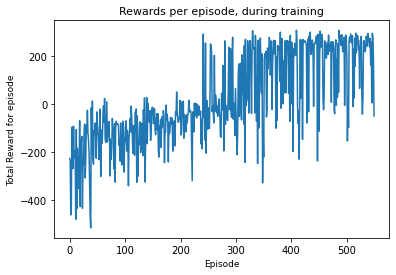

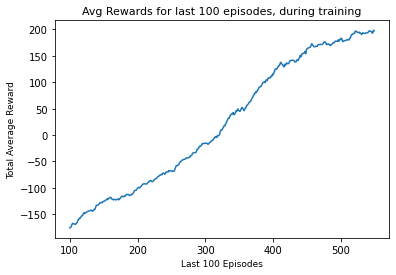


Testing...
Episode 99 : Average Reward 244.348
Episode 199 : Average Reward 240.376
Episode 299 : Average Reward 241.858


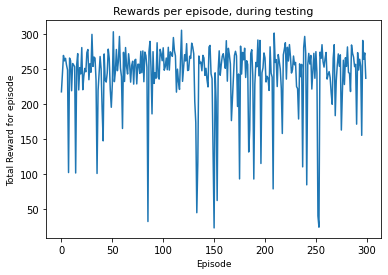

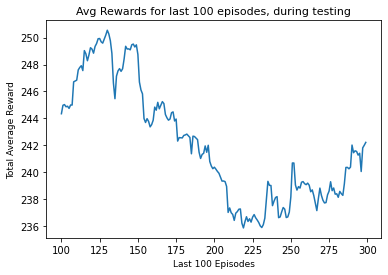

In [13]:
env = gym.make('LunarLander-v2')
env.seed(0)
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

tr_rewards, te_rewards = run_experiment1(env)